In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np
import random
from collections import deque

from DDPG import DDPGAgent

In [2]:
# Initialize env and set up hyperparameters
env = gym.make('LunarLanderContinuous-v2')
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]
min_action = env.action_space.low[0]
max_action = env.action_space.high[0]

# set seed
seed = 31
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# target update hyperparameters
start_training_after = 10001 # start training NN after this many timesteps
update_target_every = 1 # update target network every this steps
tau = 0.001

episodes = 150    
discount = 0.99
batch_size = 32
exploration_noise = 0.1
hidden_size = 64
actor_lr = 0.0005
critic_lr = 0.0005
reward_scale = 0.01

# create DDPG Agent
agent = DDPGAgent(state_size=state_size, 
                  action_size=action_size, 
                  hidden_size=hidden_size, 
                  actor_lr=actor_lr, 
                  critic_lr=critic_lr, 
                  discount=discount, 
                  min_action=min_action,
                  max_action=max_action, 
                  exploration_noise=exploration_noise)

### The RL Training Loop
In the loop, we iterate through our episodes and then the timesteps within the episodes. We stop training the agent based on some stopping condition like a max episode value, a max timestep value, or if the agent's performance reaches a certain level.

In each episode and at each timestep the agent selects an action, calls env.step(), and stores the sample in the replay buffer. The agent will also train the training neural network and periodically update the target network. When an episode is done the env is reset.

In [3]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_critic_loss = [], []

for ep in range(episodes):
    state, _ = env.reset()

    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  

    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.act(state)
        
        # enter action into the env
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        # end episode early
        if total_reward < -250:
            done = 1
        
        # add experience to replay buffer
        agent.remember(state, action, reward, next_state, done)
        
        # train the agent
        if timesteps >= start_training_after:
            actor_loss, critic_loss = agent.train(batch_size)
            stats_actor_loss.append(actor_loss) 
            stats_critic_loss.append(critic_loss) 
            agent.update_target_network_soft(timesteps, update_target_every)
            
        if done:
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0  
            if timesteps >= start_training_after and ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    '- Timestep: {}'.format(timesteps),
                    '- Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    '- Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    '- Actor Loss: {:.4f}'.format(np.mean(stats_actor_loss)), 
                    '- Critic Loss: {:.4f}'.format(np.mean(stats_critic_loss)))
                stats_actor_loss, stats_critic_loss = [], []
            break
        
        state = next_state

c:\Users\david\OneDrive\Documenti\GitHub\Lunar_Lander_DeepRL\Continuous\DDPG\DDPG.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  state = torch.FloatTensor(state).to(device)
c:\Users\david\OneDrive\Documenti\GitHub\Lunar_Lander_DeepRL\Continuous\DDPG\DDPG.py:168: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.smooth_l1_loss(Q, y)


Episode: 90 - Timestep: 10370 - Total reward: -224.6 - Episode length: 68.0 - Actor Loss: 0.7427 - Critic Loss: 1.8605
Episode: 100 - Timestep: 11325 - Total reward: -237.3 - Episode length: 95.5 - Actor Loss: 1.2944 - Critic Loss: 1.8388
Episode: 110 - Timestep: 12738 - Total reward: -217.2 - Episode length: 141.3 - Actor Loss: 2.1581 - Critic Loss: 1.7284
Episode: 120 - Timestep: 14137 - Total reward: -177.1 - Episode length: 139.9 - Actor Loss: 3.1559 - Critic Loss: 1.6533
Episode: 130 - Timestep: 15551 - Total reward: -215.5 - Episode length: 141.4 - Actor Loss: 4.2155 - Critic Loss: 1.7229
Episode: 140 - Timestep: 17099 - Total reward: -198.4 - Episode length: 154.8 - Actor Loss: 5.3045 - Critic Loss: 1.6344


Text(0, 0.5, 'Episode Reward')

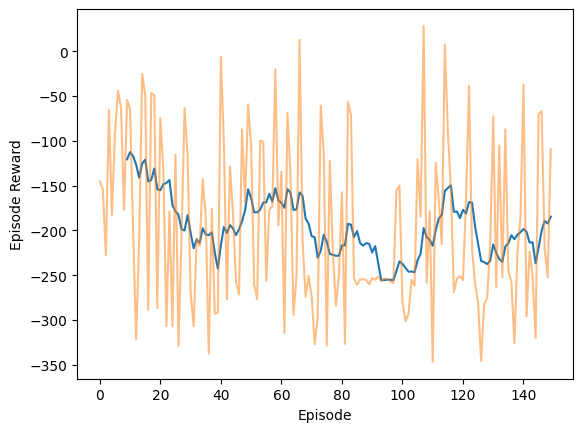

In [4]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

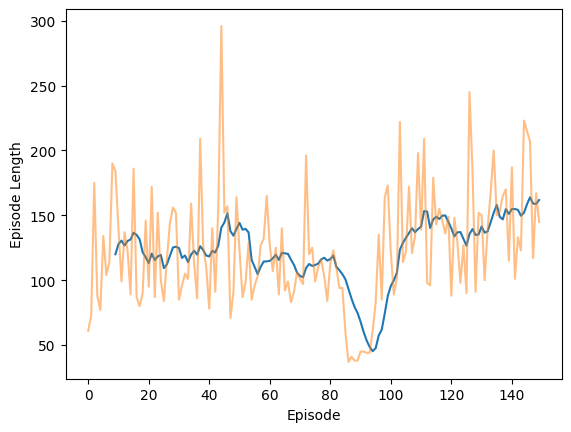

In [5]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')